In [3]:
!pip install torchensemble
!pip install torchmetrics

In [50]:
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy

In [4]:
import time
import data_prep
import os
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from collections import OrderedDict

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

from torchensemble import NeuralForestClassifier, VotingClassifier
from torchensemble.utils.logging import set_logger

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Current Path : ", os.getcwd())
os.chdir('../..')

Current Path :  /content


In [ ]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'xview_building_damage')
print("Root Data Path : ", ROOT_DATA_DIR)
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DATA_DIR)
CHALLENGE_DIR = os.path.join(ROOT_DATA_DIR, 'challenge')
TRAIN_DIR=os.path.join(CHALLENGE_DIR, 'train')
HOLD_DIR=os.path.join(CHALLENGE_DIR, 'hold')
TEST_DIR=os.path.join(CHALLENGE_DIR, 'test')

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio
Root Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train


### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
colab = True
if colab:
  train_meta_df=pd.read_csv('/content/drive/MyDrive/Capstone/csv/hc_train_hurricane-michael.csv')
  valid_meta_df=pd.read_csv( '/content/drive/MyDrive/Capstone/csv/hc_hold_hurricane-michael.csv')
  test_meta_df=pd.read_csv('/content/drive/MyDrive/Capstone/csv/hc_test_hurricane-michael.csv')
else:
  train_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'hc_train_hurricane-michael.csv'))
  valid_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv', 'hc_hold_hurricane-michael.csv'))
  test_meta_df=pd.read_csv(os.path.join(ROOT_DATA_DIR, 'challenge', 'csv' , 'hc_test_hurricane-michael.csv'))

In [25]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

valid_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [ ]:
!unzip  /content/drive/MyDrive/Capstone/train/img_mask_ov_class.zip -d /content/drive/MyDrive/Capstone/train/

In [ ]:
!unzip  /content/drive/MyDrive/Capstone/hold/img_mask_ov_class.zip -d /content/drive/MyDrive/Capstone/hold/

In [ ]:
!unzip  /content/drive/MyDrive/Capstone/test/img_mask_ov_class.zip -d /content/drive/MyDrive/Capstone/test/

In [21]:
!rm -rf /content/drive/MyDrive/Capstone/train/__MACOSX/
!rm -rf /content/drive/MyDrive/Capstone/hold/__MACOSX/
!rm -rf /content/drive/MyDrive/Capstone/test/__MACOSX/
#!rm -rf /content/drive/MyDrive/Capstone/train/destroyed/
#!rm -rf /content/drive/MyDrive/Capstone/train/major-damage/
#!rm -rf /content/drive/MyDrive/Capstone/train/minor-damage/
#!rm -rf /content/drive/MyDrive/Capstone/train/post/
#!rm -rf /content/drive/MyDrive/Capstone/train/no-damage/
#!rm -rf /content/drive/MyDrive/Capstone/hold/post/
#!rm -rf /content/drive/MyDrive/Capstone/train/classes/

In [ ]:
def get_img_class_dir(disaster_name, dataSplit, ROOT_DIR, colab=True):
 if colab:
   DIR='/content/'+dataSplit+'/post'
 else:
    DIR=os.path.join(ROOT_DIR, dataSplit,'disaster', disaster_name , 'class', 'post')
 return DIR

In [26]:

# if colab:
#   CHALLENGE_DIR = ''

train_loader, valid_loader, classes, class_to_idx = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/img_mask_ov_class/',
    '/content/drive/MyDrive/Capstone/hold/img_mask_ov_class/',
    train_transform,
    test_transform)

train_loader, test_loader, classes, class_to_idx = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/img_mask_ov_class/',
    '/content/drive/MyDrive/Capstone/test/img_mask_ov_class/',
    train_transform,
    test_transform)



print("Total Class: ", len(classes))

Train size:22454
Valid size:7072
Train size:22454
Valid size:5602
Total Class:  4


In [51]:
def test_evaluate_per_class(model, test_loader, criterion, classes):
    """
    Helper function for testing per class
    :param model: current model
    :param test_loader: test loader
    :param criterion: loss function
    :param classes: list of classes
    :return: None
    """

    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pred_list = []
    tartget_list = []

    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        target_list.extend(target)
        preds_list.extend(pred)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target) - 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    get_metrics(preds_list, target_list)

In [52]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)

    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)

    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")

    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")

    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)

In [27]:
device = 'cpu'
if torch.cuda.is_available():
 device='cuda'
elif torch.backends.mps.is_available():
 device = 'mps'

print("device = ", device)

device =  cuda


In [28]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)

    # # print(train_labels_count)

    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [29]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)

    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)

    return class_weights

In [30]:
train_labels, train_labels_count = get_label_stats(train_loader)

The number of samples per classes in training dataset:

	 0: 757
	 1: 1902
	 2: 5207
	 3: 14588


In [31]:
class_weights=get_class_weights(train_labels)
class_weights

[29.661822985468955, 11.80546792849632, 4.312271941617054, 1.5392103098437073]

In [32]:
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
# balanced sampler
weights = class_weights[train_labels]
ws = WeightedRandomSampler(weights, len(weights), replacement=True)
ws

In [43]:
train_data = datasets.ImageFolder('/content/drive/MyDrive/Capstone/train/img_mask_ov_class/', transform=train_transform)
train_loader_ws =torch.utils.data.DataLoader(
        train_data, batch_size=64, sampler=ws, num_workers=2)


In [35]:
train_loader_ws, valid_loader, classes, class_to_idx = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/img_mask_ov_class/',
    '/content/drive/MyDrive/Capstone/hold/img_mask_ov_class/',
    train_transform,
    test_transform)

train_loader_ws, test_loader, classes, class_to_idx = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/img_mask_ov_class/',
    '/content/drive/MyDrive/Capstone/test/img_mask_ov_class/',
    train_transform,
    test_transform)



print("Total Class: ", len(classes))

Train size:22454
Valid size:7072
Train size:22454
Valid size:5602
Total Class:  4


In [ ]:
densenet = models.densenet161(pretrained=True)
densenet.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 66.9MB/s]


Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
densenet = data_prep.freeze_parameters(densenet)
num_classes = 5

In [ ]:
classifier = nn.Sequential(
  nn.Linear(in_features=2208, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=1024, out_features=16),
  nn.LogSoftmax(dim=1)
)

densenet.classifier = classifier
densenet.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=16, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
densenet.to(device) ### Just for testing

criterion = nn.NLLLoss()
optimizer = optim.Adam(densenet.classifier.parameters(), lr=0.003)
# turn this off
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
epoch = 5

In [ ]:
densenet, train_loss, test_loss = data_prep.train(densenet, train_loader, test_loader, epoch, optimizer, criterion)

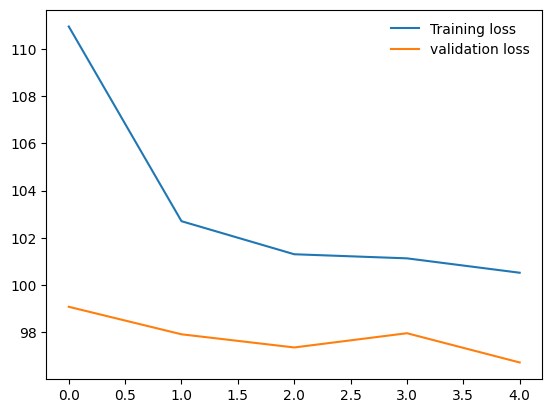

In [ ]:
data_prep.check_overfitted(train_loss, test_loss)

In [ ]:
epoch = 20

In [ ]:
densenet, train_loss, test_loss = data_prep.train(densenet, train_loader, valid_loader, epoch, optimizer, criterion)

Epoch: 1/20
		Going for validation
	Train loss:1.058224.. 	Valid Loss:1.045890.. 	Accuracy: 62.2660
	Validation loss decreased (inf --> 1.045890).  Saving model ...
	Epoch:1 completed in 94m 36s
Epoch: 2/20
		Going for validation
	Train loss:1.018263.. 	Valid Loss:1.035331.. 	Accuracy: 62.2660
	Validation loss decreased (1.045890 --> 1.035331).  Saving model ...
	Epoch:2 completed in 15m 2s
Epoch: 3/20
		Going for validation
	Train loss:1.013050.. 	Valid Loss:1.023710.. 	Accuracy: 62.2660
	Validation loss decreased (1.035331 --> 1.023710).  Saving model ...
	Epoch:3 completed in 14m 38s
Epoch: 4/20
		Going for validation
	Train loss:1.009491.. 	Valid Loss:1.026859.. 	Accuracy: 62.2660
	Epoch:4 completed in 14m 32s
Epoch: 5/20
		Going for validation
	Train loss:1.004185.. 	Valid Loss:1.050811.. 	Accuracy: 62.0704
	Epoch:5 completed in 15m 6s
Epoch: 6/20
		Going for validation
	Train loss:1.005280.. 	Valid Loss:1.033557.. 	Accuracy: 62.2660
	Epoch:6 completed in 14m 29s
Epoch: 7/20
		Goi

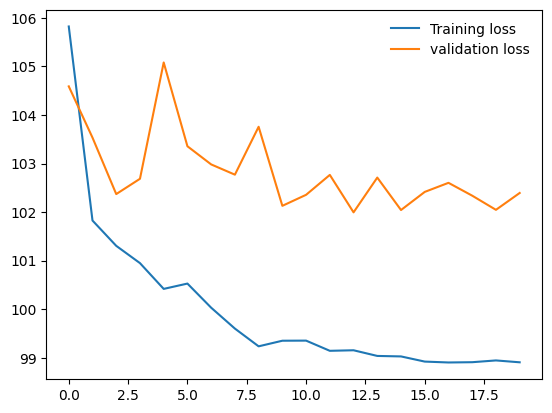

In [ ]:
data_prep.check_overfitted(train_loss, test_loss)

In [ ]:
data_prep.test(densenet, test_loader)

Accuracy: 64.0274


In [ ]:
data_prep.test_per_class(densenet, test_loader, criterion, classes)

Test Loss: 0.967869

Test Accuracy of     0:  0% ( 0/181)
Test Accuracy of     1:  0% ( 0/402)
Test Accuracy of     2:  0% ( 0/1342)
Test Accuracy of     3: 100% (3590/3590)
Test Accuracy of     4:  0% ( 0/53)

Test Accuracy (Overall): 64% (3590/5568)


### Resnet

In [36]:
resnet = models.resnet50(pretrained=True)
resnet.fc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


Linear(in_features=2048, out_features=1000, bias=True)

In [37]:
resnet = data_prep.freeze_parameters(resnet)

In [41]:
classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=1024, out_features=16),
  nn.LogSoftmax(dim=1)
)
criterion = nn.CrossEntropyLoss()

resnet.fc = classifier
resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=16, bias=True)
  (4): LogSoftmax(dim=1)
)

In [45]:
#device ='cpu'
resnet.to(device)
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.0001)
#optimizer1 = optim.AdamW(resnet.fc.parameters(), weight_decay= 0.03, lr=0.0015)
# turn this off

scheduler = optim.lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.1)

In [46]:
epoch = 10
resnet, train_loss, test_loss = data_prep.train(resnet, train_loader, test_loader, epoch, optimizer, criterion)

Epoch: 1/10
		Going for validation
	Train loss:0.998860.. 	Valid Loss:0.924070.. 	Accuracy: 65.0839
	Validation loss decreased (inf --> 0.924070).  Saving model ...
	Epoch:1 completed in 15m 38s
Epoch: 2/10
		Going for validation
	Train loss:0.952058.. 	Valid Loss:0.916555.. 	Accuracy: 65.0839
	Validation loss decreased (0.924070 --> 0.916555).  Saving model ...
	Epoch:2 completed in 14m 47s
Epoch: 3/10
		Going for validation
	Train loss:0.943120.. 	Valid Loss:0.917755.. 	Accuracy: 65.1017
	Epoch:3 completed in 14m 39s
Epoch: 4/10
		Going for validation
	Train loss:0.942273.. 	Valid Loss:0.915618.. 	Accuracy: 65.1196
	Validation loss decreased (0.916555 --> 0.915618).  Saving model ...
	Epoch:4 completed in 14m 22s
Epoch: 5/10
		Going for validation
	Train loss:0.940076.. 	Valid Loss:0.914818.. 	Accuracy: 65.1017
	Validation loss decreased (0.915618 --> 0.914818).  Saving model ...
	Epoch:5 completed in 14m 17s
Epoch: 6/10
		Going for validation
	Train loss:0.935940.. 	Valid Loss:0.909

In [49]:
!pip  install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00


In [54]:
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy

In [59]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)

    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)

    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")

    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")

    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)

def test_evaluate_per_class(model, test_loader, criterion, classes):
    """
    Helper function for testing per class
    :param model: current model
    :param test_loader: test loader
    :param criterion: loss function
    :param classes: list of classes
    :return: None
    """

    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pred_list = []
    tartget_list = []

    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        tartget_list.extend(target)
        pred_list.extend(pred)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target) - 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    get_metrics(pred_list, tartget_list)

In [60]:
data_prep.test_per_class(resnet, test_loader, criterion, classes)

Test Loss: 0.902065

Test Accuracy of     0:  0% ( 0/181)
Test Accuracy of     1:  0% ( 1/402)
Test Accuracy of     2:  0% ( 5/1342)
Test Accuracy of     3: 99% (3583/3589)

Test Accuracy (Overall): 65% (3589/5514)


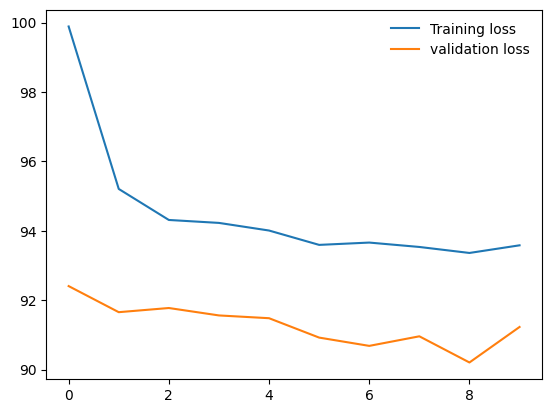

In [61]:
data_prep.check_overfitted(train_loss, test_loss)

In [64]:
import torch
from torch import tensor
test_evaluate_per_class(resnet, test_loader, criterion, classes)

Test Loss: 0.902065

Test Accuracy of     0:  0% ( 0/181)
Test Accuracy of     1:  0% ( 1/402)
Test Accuracy of     2:  0% ( 5/1342)
Test Accuracy of     3: 99% (3583/3589)

Test Accuracy (Overall): 65% (3589/5514)
Accuracy : tensor(0.6510)
F1-score :  tensor(0.5156)
Precision :  tensor(0.5423)
Recall :  tensor(0.6510)


#### End


Weighted Resnet

In [ ]:
epoch = 25
resnet, train_loss, test_loss = data_prep.train(resnet, train_loader_ws, test_loader, epoch, optimizer, criterion)

Epoch: 1/25
		Going for validation
	Train loss:1.101048.. 	Valid Loss:0.990544.. 	Accuracy: 64.4688
	Validation loss decreased (inf --> 0.990544).  Saving model ...
	Epoch:1 completed in 12m 57s
Epoch: 2/25
		Going for validation
	Train loss:1.040875.. 	Valid Loss:0.974887.. 	Accuracy: 64.4688
	Validation loss decreased (0.990544 --> 0.974887).  Saving model ...
	Epoch:2 completed in 11m 54s
Epoch: 3/25
		Going for validation
	Train loss:1.028727.. 	Valid Loss:0.977056.. 	Accuracy: 64.4688
	Epoch:3 completed in 11m 54s
Epoch: 4/25
		Going for validation
	Train loss:1.012041.. 	Valid Loss:0.995058.. 	Accuracy: 64.4688
	Epoch:4 completed in 11m 52s
Epoch: 5/25
		Going for validation
	Train loss:1.012426.. 	Valid Loss:0.976065.. 	Accuracy: 64.4688
	Epoch:5 completed in 11m 55s
Epoch: 6/25
		Going for validation
	Train loss:1.007132.. 	Valid Loss:0.972628.. 	Accuracy: 64.4688
	Validation loss decreased (0.974887 --> 0.972628).  Saving model ...
	Epoch:6 completed in 11m 55s
Epoch: 7/25
		G

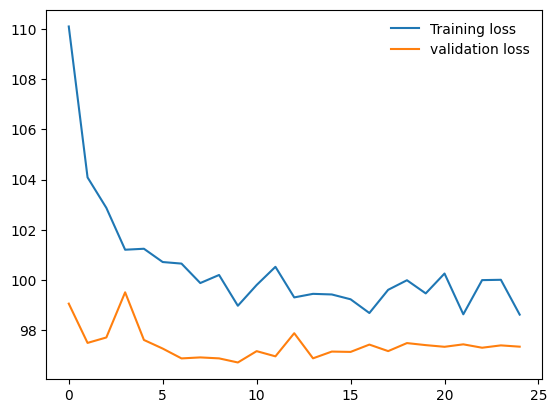

In [ ]:
data_prep.check_overfitted(train_loss, test_loss)

In [ ]:
data_prep.test(densenet, test_loader)

Accuracy: 64.0274


In [ ]:
data_prep.test_per_class(densenet, test_loader, criterion, classes)

Test Loss: 0.967869

Test Accuracy of     0:  0% ( 0/181)
Test Accuracy of     1:  0% ( 0/402)
Test Accuracy of     2:  0% ( 0/1342)
Test Accuracy of     3: 100% (3590/3590)
Test Accuracy of     4:  0% ( 0/53)

Test Accuracy (Overall): 64% (3590/5568)


Epoches = 50

In [ ]:
epoch = 50
resnet, train_loss, test_loss = data_prep.train(resnet, train_loader_ws, test_loader, epoch, optimizer1, criterion)

NameError: name 'data_prep' is not defined

In [ ]:
data_prep.check_overfitted(train_loss, test_loss)

#### Inception Model v3

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize(299),
                                transforms.RandomResizedCrop(299),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


test_transform = transforms.Compose([
                                transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [ ]:
train_loader_inc, test_loader_inc, classes_inc, class_to_idx_inc = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/post/',
    '/content/drive/MyDrive/Capstone/test/post/',
    train_transform,
    test_transform,
    num_workers=4
)

train_loader_inc, test_loader_inc, classes_inc, class_to_idx_inc = data_prep.prepare_loader(
    '/content/drive/MyDrive/Capstone/train/post/',
    '/content/drive/MyDrive/Capstone/test/post/',
    train_transform,
    test_transform,
    num_workers=4
)

print("Total Class: ", len(classes))

Train size:22686
Valid size:5657
Total Class:  5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
incept = models.inception_v3(pretrained=True)

print(incept.fc)
incept.aux_logits = True
print(incept.aux_logits)

In [ ]:
incept = data_prep.freeze_parameters(incept)

### VGG 16

In [ ]:
vgg = models.vgg16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.2MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)
True


In [ ]:
classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=1024, out_features=5),
  nn.LogSoftmax(dim=1)
)

classifier2 = nn.Sequential(
  nn.Linear(in_features=786, out_features=512),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=512, out_features=5),
  nn.LogSoftmax(dim=1)
)
vgg.fc = classifier
#incept.fc = classifier
#incept.AuxLogits.fc = classifier2

print(vgg.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
vgg.to(device)
optimizer = optim.Adam(vgg.fc.parameters(),lr=0.003)
# turn this off
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
incept.to(device)
optimizer = optim.Adam(incept.fc.parameters(),lr=0.003)
# turn this off
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
vgg, train_loss, test_loss = data_prep.train(vgg, train_loader_inc, test_loader_inc, epoch, optimizer, criterion)

Epoch: 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


		Going for validation
	Train loss:-0.467551.. 	Valid Loss:-0.557683.. 	Accuracy: 0.0000
	Validation loss decreased (inf --> -0.557683).  Saving model ...
	Epoch:1 completed in 9m 56s
Epoch: 2/5
		Going for validation
	Train loss:-0.457261.. 	Valid Loss:-0.557683.. 	Accuracy: 0.0000
	Epoch:2 completed in 9m 42s
Epoch: 3/5
		Going for validation
	Train loss:-0.467759.. 	Valid Loss:-0.557683.. 	Accuracy: 0.0000
	Epoch:3 completed in 9m 49s
Epoch: 4/5
		Going for validation
	Train loss:-0.467148.. 	Valid Loss:-0.557683.. 	Accuracy: 0.0000
	Epoch:4 completed in 9m 41s
Epoch: 5/5
		Going for validation
	Train loss:-0.457489.. 	Valid Loss:-0.557683.. 	Accuracy: 0.0000
	Epoch:5 completed in 9m 48s
Training completed in 48m 56s


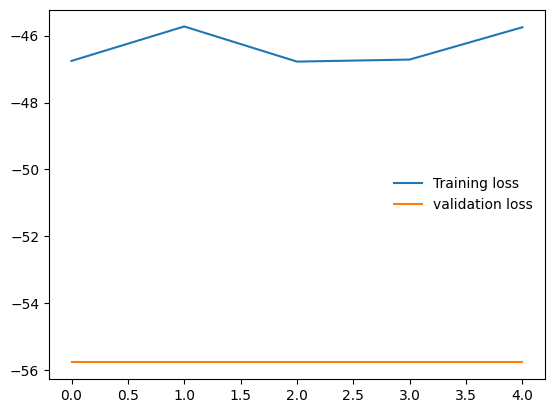

In [ ]:
data_prep.check_overfitted(train_loss, test_loss)

#### Ensembling

In [ ]:
class BuildingClassifierEnsemble(nn.Module):

    def __init__(self, modelA, modelB, modelC, input):
        super(BuildingClassifierEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

        self.fc1 = nn.Linear(input, 5)

    def forward(self, x):
        out1 = self.modelA(x)
        out2 = self.modelB(x)
        out3 = self.modelC(x)

        out = out1 + out2 + out3

        x = self.fc1(out)
        return torch.softmax(x, dim=1)

In [ ]:
model = BuildingClassifierEnsemble(densenet, resnet, vgg, 5)

In [ ]:
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.003)
# turn this off
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model, train_loss, test_loss = data_prep.train(model, train_loader, test_loader, epoch, optimizer, criterion)

NameError: name 'data_prep' is not defined